In [15]:
!pip install yfinance pandas numpy matplotlib --quiet
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 6)


In [16]:
ticker = "HDFCBANK.NS"   # liquid NSE stock

print(f"Downloading intraday data for {ticker} ...")

data = yf.download(
    ticker,
    period="5d",      # last 5 trading days
    interval="5m",    # 5-minute bars
    auto_adjust=False
)

# Handle multiindex columns (Price, Ticker) -> flatten to "OHLCV" only
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(1)  # drop ticker level

data = data.dropna()
print("\nColumns:", data.columns)
data.head()


[*********************100%***********************]  1 of 1 completed


Columns: Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


Price,Adj Close,Close,High,Low,Open,Volume
Datetime,,,,,,
2025-12-01 03:45:00+00:00,1010.799988,1010.799988,1016.900024,1010.200012,1016.900024,0
2025-12-01 03:50:00+00:00,1010.799988,1010.799988,1011.500000,1009.299988,1010.799988,328709
2025-12-01 03:55:00+00:00,1010.000000,1010.000000,1011.500000,1009.500000,1011.099976,178673
2025-12-01 04:00:00+00:00,1014.200012,1014.200012,1014.900024,1010.000000,1010.000000,223143
2025-12-01 04:05:00+00:00,1013.200012,1013.200012,1014.900024,1011.799988,1014.200012,263697


In [17]:
mid_price = (data['High'] + data['Low']) / 2
spread = 0.0002  # 2 bps spread

inventory = 0
cash = 0

buy_quotes = []
sell_quotes = []
positions = []
pnl_values = []


In [22]:
for price in mid_price:
    # Market maker quotes bid & ask
    bid = price * (1 - spread)
    ask = price * (1 + spread)
    
    # Assumed some random market orders hit our quotes 
    # 50% chance of either side
    hit = np.random.choice(['buy', 'sell', 'none'], p=[0.4, 0.4, 0.2])
    
    if hit == 'buy':   # someone buys from us → we sell at ask
        inventory -= 1
        cash += ask
    
    if hit == 'sell':  # someone sells to us → we buy at bid
        inventory += 1
        cash -= bid

    # market P&L
    pnl = cash + inventory * price

    buy_quotes.append(bid)
    sell_quotes.append(ask)
    pnl_values.append(pnl)
    positions.append(inventory)


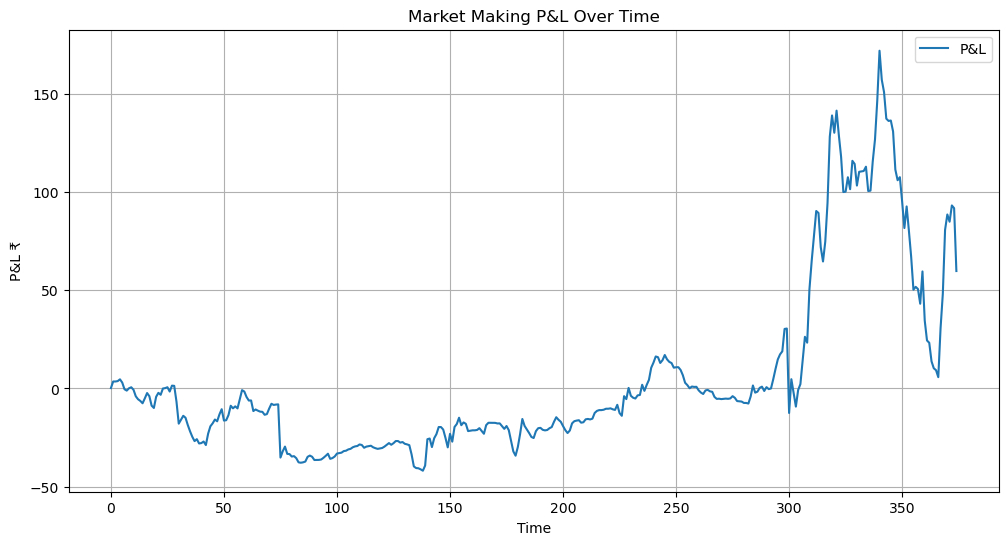

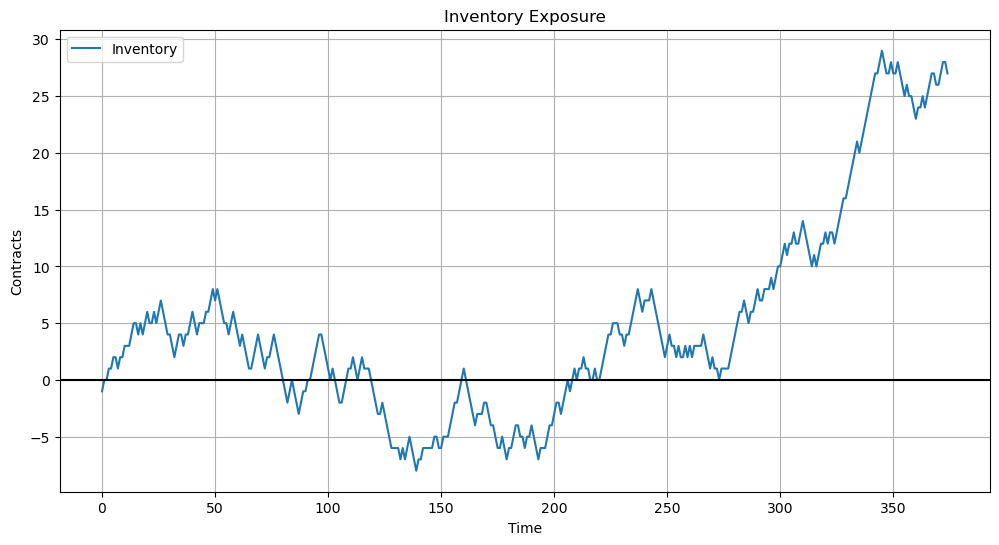

In [19]:
plt.plot(pnl_values, label='P&L')
plt.title('Market Making P&L Over Time')
plt.xlabel('Time')
plt.ylabel('P&L ₹')
plt.grid(True)
plt.legend()
plt.show()

plt.plot(positions, label='Inventory')
plt.axhline(0, color='black')
plt.title('Inventory Exposure')
plt.xlabel('Time')
plt.ylabel('Contracts')
plt.grid(True)
plt.legend()
plt.show()


In [20]:
print("===== Market Making Performance =====")
print(f"Final P&L: ₹{pnl_values[-1]:.2f}")
print(f"Max Inventory: {np.max(np.abs(positions))} lots")
print(f"Hit Rate: ~{(np.count_nonzero(np.array(positions) != 0) / len(positions)) * 100:.1f}%")


===== Market Making Performance =====
Final P&L: ₹59.80
Max Inventory: 29 lots
Hit Rate: ~94.4%
